In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel

from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

In [45]:
marzo = pd.read_csv('marzo.csv')
#abril = pd.read_csv('abril.csv')
#mayo = pd.read_csv('mayo.csv')
#df = pd.concat([marzo,abril,mayo], axis = 0)
df = marzo.sample(n = 100000)
del marzo

In [46]:
df.head()

,organismosolicitante,agilebuyingscode,agilebuyingsdescription,agilebuyingsstatus,agilebuyingscurrency,agilebuyingsavailableamount,agileitemsname,agileitemsmp_id,agileitemsproductcategory,agileoffereditemsproductoofertado,agileoffereditemscategoriaofertada,agileoffereditemsdescripcionofertada,agileoffereditemspreciototal,taxnumberprovider,provideractivity,adjudicada
436440,69.200.800-6,3334-125-COT23,Se requiere cotizar productos de aseo para Ces...,OC Emitida,CLP,1800000.0,Paños de limpieza,47131502,Equipos y suministros de limpieza / Suministro...,Paños de limpieza,Trapos y paños de limpieza,Trapero algodon con ojal 50x70 cms,164000.0,96.670.840-9,VENTA AL POR MAYOR DE OTROS PRODUCTOS N.C.P.| ...,False
340536,70.770.800-k,5952-17-COT23,Se solicita escritorio en L 150x150 cm. con ca...,Cancelada,$,1450000.0,Escritorios,56101703,Muebles y mobiliario / Muebles de alojamiento ...,Escritorios,Muebles de oficina,escritorio en L 150x150 cm. con cajoneras Kard...,680000.0,10.232.710-1,CULTIVO DE POROTOS| CULTIVO DE HORTALIZAS Y ME...,False
491683,61.004.051-9,1391-172-COT23,CCP CURICÓ REQUIERE LA COMPRA DE MATERIALES Y ...,OC Emitida,$,1000000.0,Guantes o manoplas,53102504,"Ropa, maletas y productos de aseo personal / R...",Guantes o manoplas,Accesorios de vestir,Guantes látex de limpieza multiuso talla L par,36000.0,77.095.492-4,VENTA AL POR MENOR DE OTROS PRODUCTOS EN COMER...,False
369529,71.149.700-5,545598-50-COT23,"Se requiere adquirir equipo Pc., computador ma...",Cerrada,$,1850000.0,Computadores de escritorio,43211507,"Tecnologías de la información, telecomunicacio...",Computadores de escritorio,Computadores,"Se requiere adquirir equipo Pc., computador ma...",1260496.0,76.662.711-0,"VENTA AL POR MENOR DE COMPUTADORES, EQUIPO PER...",False
41581,61.101.015-K,3481-71-COT23,Se solicita cotización de materiales de oficin...,OC Emitida,CLP,630000.0,Sobres estándar,44121506,"Equipos, accesorios y suministros de oficina /...",Saca corchetes,Suministros de escritorio,saca corchetes tenazas,1900.0,78.307.160-6,Distribucion de Articulos de Aseo y de Oficina,False


In [47]:
df.describe()

,agilebuyingsavailableamount,agileitemsmp_id,agileoffereditemspreciototal
count,1.000000e+05,1.000000e+05,1.000000e+05
mean,9.900647e+05,4.651358e+07,2.372567e+05
std,6.203682e+05,4.083611e+06,3.403817e+05
min,1.000000e+00,4.212150e+07,0.000000e+00
25%,4.300000e+05,4.321171e+07,2.392725e+04
50%,9.100000e+05,4.412210e+07,8.945500e+04
75%,1.688000e+06,5.013180e+07,2.940000e+05
max,1.873499e+06,5.612200e+07,1.800000e+06


<AxesSubplot:>

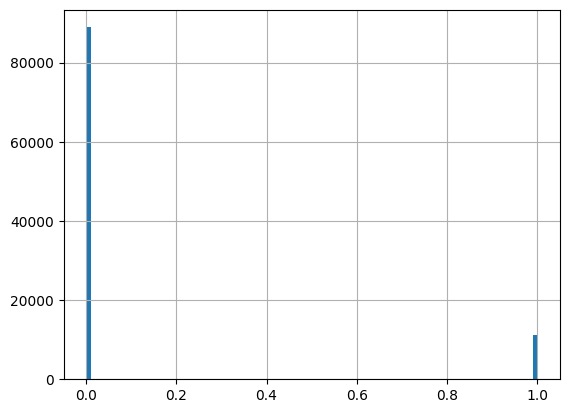

In [48]:
df['numeric'] = df['adjudicada'].apply(lambda x: 1 if x == True else 0)
df['numeric'].hist(bins = 100)

numeric        total adj_rate
adjudicada          False  True                
taxnumberprovider                              
10.025.673-8         20.0   0.0   20.0     0.00
10.232.710-1         50.0   5.0   55.0     0.09
10.292.719-2          4.0   8.0   12.0     0.67
10.365.318-5         43.0   0.0   43.0     0.00
10.531.697-6        388.0   6.0  394.0     0.02
...                   ...   ...    ...      ...
99.569.670-3         46.0   0.0   46.0     0.00
99.571.800-6          8.0   4.0   12.0     0.33
99.574.460-0         53.0   4.0   57.0     0.07
99.576.080-0         19.0   4.0   23.0     0.17
99.593.170-2        237.0  14.0  251.0     0.06

[1340 rows x 4 columns]

<AxesSubplot:title={'center':'Distribución de rate de adjudicación. n> 10 participaciones'}, ylabel='Density'>

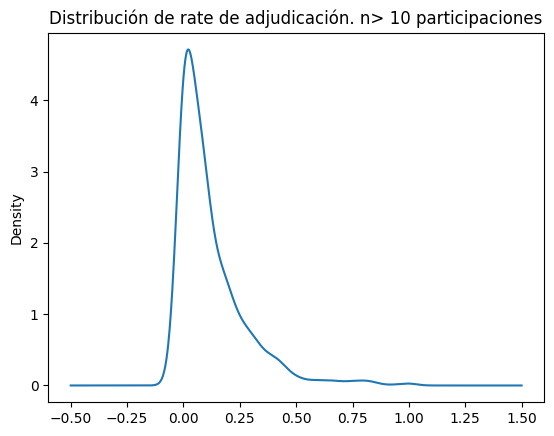

In [49]:
gb = df[['taxnumberprovider','adjudicada', 'numeric']].groupby(by=['taxnumberprovider','adjudicada']).count()
gb = gb.unstack().fillna(0)


gb['total'] = gb[('numeric', False)] +  gb[('numeric', True)]
gb['adj_rate'] =( gb[('numeric', True)]/gb['total']).round(2)
gb = gb[gb['total'] >= 10]
display(gb)

gb['adj_rate'].plot.density(title= 'Distribución de rate de adjudicación. n> 10 participaciones')

Text(0.5, 1.0, 'Distribución probabilidad de adjudicaciones por usuario, todos los rubros.')

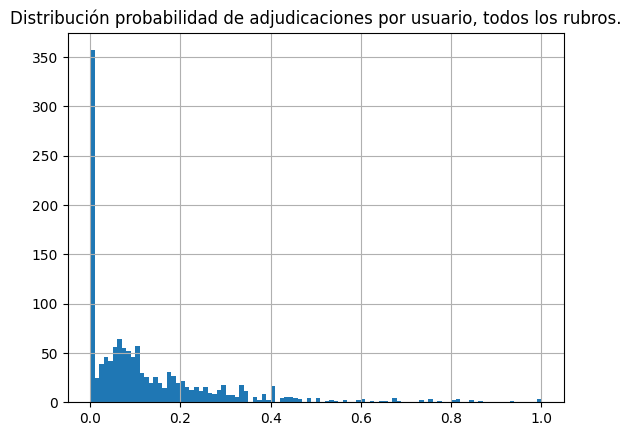

In [50]:
ax = gb['adj_rate'].hist(bins = 100)
plt.title('Distribución probabilidad de adjudicaciones por usuario, todos los rubros.')

In [51]:
gb = gb.reset_index()
gb

taxnumberprovider numeric        total adj_rate
adjudicada                     False  True                
0               10.025.673-8    20.0   0.0   20.0     0.00
1               10.232.710-1    50.0   5.0   55.0     0.09
2               10.292.719-2     4.0   8.0   12.0     0.67
3               10.365.318-5    43.0   0.0   43.0     0.00
4               10.531.697-6   388.0   6.0  394.0     0.02
...                      ...     ...   ...    ...      ...
1335            99.569.670-3    46.0   0.0   46.0     0.00
1336            99.571.800-6     8.0   4.0   12.0     0.33
1337            99.574.460-0    53.0   4.0   57.0     0.07
1338            99.576.080-0    19.0   4.0   23.0     0.17
1339            99.593.170-2   237.0  14.0  251.0     0.06

[1340 rows x 5 columns]

In [52]:
gb_merge= gb[['taxnumberprovider','total','adj_rate']]

In [53]:
merge = pd.merge(df,gb_merge, on = 'taxnumberprovider', how = 'left')
#print(merge.columns)
merge = merge.rename(columns={('total', ''):'total',
                             ('adj_rate', ''):'adj_rate'})
merge = merge.dropna()

/tmp/ipykernel_4060/3228539258.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  merge = pd.merge(df,gb_merge, on = 'taxnumberprovider', how = 'left')
/tmp/ipykernel_4060/3228539258.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  merge = pd.merge(df,gb_merge, on = 'taxnumberprovider', how = 'left')


In [54]:

import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel
import pymc as pm
import arviz as az

In [55]:
merge.describe()

,agilebuyingsavailableamount,agileitemsmp_id,agileoffereditemspreciototal,numeric,total,adj_rate
count,8.855300e+04,8.855300e+04,8.855300e+04,88553.000000,88553.000000,88553.000000
mean,9.933540e+05,4.635101e+07,2.287208e+05,0.104491,378.436507,0.104456
std,6.212536e+05,4.036250e+06,3.335528e+05,0.305898,506.274348,0.109231
min,1.000000e+00,4.212150e+07,0.000000e+00,0.000000,10.000000,0.000000
25%,4.300000e+05,4.321151e+07,2.217000e+04,0.000000,59.000000,0.030000
50%,9.200000e+05,4.412200e+07,8.400000e+04,0.000000,176.000000,0.070000
75%,1.700000e+06,4.924170e+07,2.780000e+05,0.000000,464.000000,0.150000
max,1.873499e+06,5.612200e+07,1.574369e+06,1.000000,2183.000000,1.000000


In [56]:
observed_data = merge['adj_rate']
observed_data = np.clip(observed_data,0.01,0.99)


In [57]:
with pm.Model() as model_g:
    # Variables exógenas
    mean, sigma = 0.5, 0.5
    mu = pm.TruncatedNormal('$\mu$', mu=mean, sigma=sigma, lower=0, upper=1) # N(0.5, 0.5) * T(0, 1)

    shape, scale = 3, 0.1
    psi = pm.Gamma('$\psi$', mu=shape, sigma=scale)
    alpha, beta = mu * psi, (1 - mu) * psi
    # Variable endógena
    y = pm.Beta('y', alpha=alpha, beta=beta, observed=observed_data)

    trace_g = pm.sample(1000)
#model.debug()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [$\mu$, $\psi$]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


array([[<AxesSubplot:title={'center':'$\\mu$'}>,
        <AxesSubplot:title={'center':'$\\mu$'}>],
       [<AxesSubplot:title={'center':'$\\psi$'}>,
        <AxesSubplot:title={'center':'$\\psi$'}>]], dtype=object)

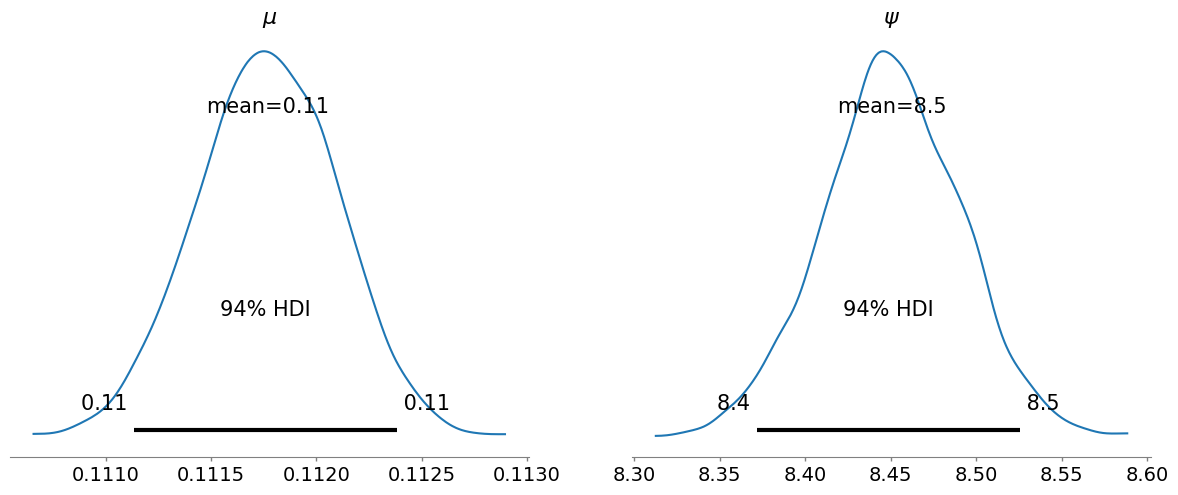

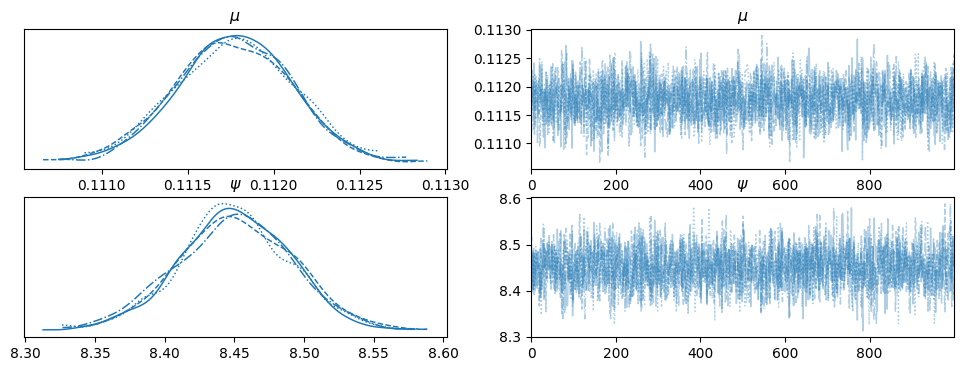

In [58]:
# Assuming the code above has been executed
# Access the summary statistics of the posterior distribution
summary = pm.summary(trace_g)

# Access the posterior samples for individual parameters
trace_samples_mu = trace_g.posterior['$\mu$'].values
trace_samples_psi = trace_g.posterior['$\psi$'].values

# Plot posterior distributions
pm.plot_posterior(trace_g)

# Plot trace plots (using pymc.plot_trace or arviz.plot_trace)
pm.plot_trace(trace_g)
# or
# import arviz as az
# az.plot_trace(trace_g)

In [59]:
import matplotlib.pyplot as plt

# Assuming the code for model specification and sampling has been executed

# Generate simulated data using the posterior samples
simulated_data = pm.sample_posterior_predictive(trace_g,  model=model_g)
print(simulated_data.keys())


Sampling: [y]


KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)


In [ ]:
print(simulated_data['posterior_predictive'].to_array())

ValueError: x must have 2 or fewer dimensions

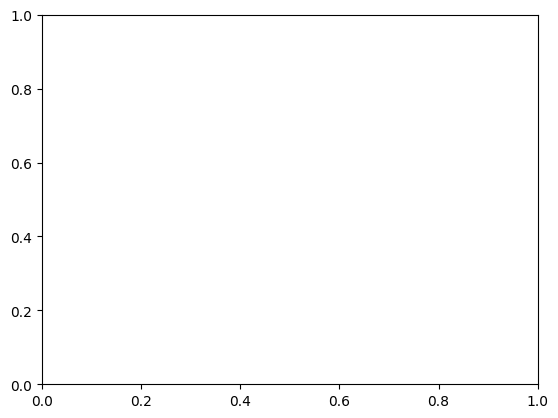

In [63]:
# Plot the original data
#plt.hist(observed_data, bins=100, alpha=0.5, label='Original Data', color='blue')

# Plot the simulated data
plt.hist(simulated_data['posterior_predictive'].squeeze(), bins=100, alpha=0.5, label='Simulated Data', color='orange')

# Add labels and legend
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

### Regresión beta??